# Deep learning lab 2: Transformers and self-attention

Last update: VT2026

The goal of this lab is that you get some hands on experience with the transformer architecture. In the first part of the lab we will work with the self-attention mechanism and implement it in pytorch. For this part the content from the first Lecture on Transformers is sufficient. In the second part we will train two different transformer architectures with different tasks. In the outro session of the lab you are asked to present the solution to the questions of the lab to the teachers.

In [55]:
import matplotlib.pyplot as plt

import numpy as np
import torch

An important part of the Transformer architecture is the fully-connected neural network which we have seen in Assignment and Lab 1. Typically, a neural network with one hidden layer is used for this with the hidden dimension being 4 times larger than the input/output dimension. We use the GeLU non-linear activation function, which is a smoothed out version of the ReLU function you have seen in the previous sessions, for the non-linearity as it is the default choice for Transformer layers. By now, you should be familiar with this general architecture and understand the implementation below.

In [56]:
class MLP(torch.nn.Module):
    def __init__(self, input_dimension):
        super().__init__()
        self.c_fc = torch.nn.Linear(input_dimension, 4 * input_dimension)
        self.gelu = torch.nn.GELU(approximate='tanh')
        self.c_proj = torch.nn.Linear(4 * input_dimension, input_dimension)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

## Part 1: Self-attention mechanism

The self-attention mechanism in matrix form is given by the following equations. For more details you can check Section 12.2.4 in the course book.

$$
\mathbf{Sa}[\mathbf{X}] = \mathbf{V}[\mathbf{X}] \cdot \mathbf{Softmax} \left[ \mathbf{K}[\mathbf{X}]^T \mathbf{Q}[\mathbf{X}] \right]
$$

where $\mathbf{Q[X]}$, $\mathbf{K[X]}$, $\mathbf{V[X]}$ are the Key, Query and Value matrices given by linear transformations of the input $x$ to the layer:

\begin{align}
\mathbf{Q}[\mathbf{X}] = \mathbf{\beta_q 1^T + \Omega_q X} \\
\mathbf{K}[\mathbf{X}] = \mathbf{\beta_k 1^T + \Omega_k X} \\
\mathbf{V}[\mathbf{X}] = \mathbf{\beta_v 1^T + \Omega_v X}
\end{align}

Similar to the book, we do not include the dependence of $\mathbf{Q}$, $\mathbf{K}$, $\mathbf{V}$ on the input $\mathbf{X}$ in the following. Note in particular that the input and output dimensions are the same for the layer.

TransformerBlockSA.svg

When implementing the architecture in pytorch, we rely on the transposed version of the self-attention since we additionally have a batch dimension. The input itself is usually of dimension $(B, N, D)$ where $B$ is the batch size, $N$ is the number of tokens / elements in the sequence and $D$ is the dimensionality of the input also refred to as input embedding.
In its transposed form, the self-attention mechanism can be written as:

$$
\mathbf{Sa}[\mathcal{X}] = \mathbf{Softmax} \left[\mathcal{Q}[\mathcal{X}]  \mathcal{K}[\mathcal{X}]^T \right] \cdot \mathcal{V}[\mathcal{X}]
$$

which is the transposed version of the equation shown above where $\mathcal{X}$ is the input tensor of size $N \times D$. The softmax operation above should be applied row-wise in this case. For an efficient implementation, use the transposed formulation above when implementing the modules in the lab.
This forumlation also allows us to easily parallelize over multiple batches by including the batch dimension as the first dimension of the input tensor. PyTorch parallelizes over the leading dimensions the standard operations using broadcasting.

**Question 1**: What size do the Key, Value and Query matrices have in the expression above? All matrices are the same size and the dimension of the input is not supposed to change after the layer.

**Task 1**: In the init method of the single-head self attention, create the parameterized layers that are required to compute the output of the mechanism described above.

**Task 2**: Write the forward pass of the module to implement the self-attention mechanism. Return both the output tokens as well as the attention matrix itself as a second return argument.

_Hints_:
- Learned matrix-vector products can be efficiently implemented using linear layers using torch.nn.Linear.
- When using a transformer, the input usually is a tensor of size (batch_size, num_tokens, embedding_size) = $(B, N, D)$ so be careful when transposing tensors. Using the function .transpose() you can pass the dimensions you want to transpose as an input argument.

In [62]:
class SingleHeadSelfAttention(torch.nn.Module):

    def __init__(self, embedding_dimension):
        super().__init__()
        # TODO: implement the key, query and value operators using torch.nn.Linear
        self.key   = torch.nn.Linear(embedding_dimension, embedding_dimension, bias=False)
        self.query = torch.nn.Linear(embedding_dimension, embedding_dimension, bias=False)
        self.value = torch.nn.Linear(embedding_dimension, embedding_dimension, bias=False)

    def forward(self, x):
        # TODO: implement forward pass here
        B, N, D = x.size()
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        att = (Q @ K.transpose(-2, -1)) * (D ** -0.5)
        att = torch.nn.functional.softmax(att, dim=-1)
        out = att @ V

        # return the new tokens and the attention matrix
        return out, att

In [63]:
# Create a single head self-attention layer with embedding size 32
sa = SingleHeadSelfAttention(32)

# create a normally distributed vectors
# vector x is of size (BATCHSIZE, NUM_TOKENS, EMBEDDING_SIZE) = (B, N, D)
x = torch.empty((2, 10, 32)).normal_()
out, att = sa(x)

**Question 2**: What size is the attention matrix that gets returned by the single-head layer? What constraints must the attention matrix and its elements fulfill in terms of the attention matrix size and the values that the elements in the matrix take?

_Hint_: you can look at the following easy checks that verify the constraints of the computed attention matrices.

In [64]:
# the attention matrix should be of size (B, N, N)
att.shape

torch.Size([2, 10, 10])

In [65]:
# all elements in the attention matrix should be non-negative
torch.where(att < 0)

(tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64))

In [66]:
# the rows in the attention matrix should sum to one
torch.sum(att, dim=-1)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]], grad_fn=<SumBackward1>)

Now, we have managed to implement the heart of the transformer -- the self-attention mechamism. In the following, we will extend the architecture to include normalization, multiple attention heads, and passing the results through non-linear MLPs.

In the cell below, you can see a visualization of the attention matrix of the initalized transformer.

**Question 3**: What can you observe about the distribution of attention scores? Why is this problem arising and how can we avoid this?

_Hint_: Look at the difference between the largest and smallest element in the attention matrix. Optionally, you can also change the sequence length to see the behaviour for different sizes of attention matrices.

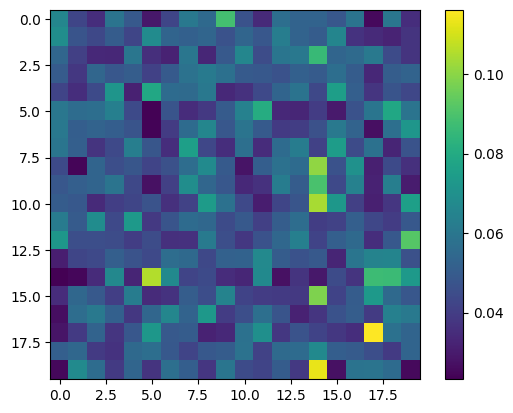

In [67]:
# create a normally distributed vectors
# vector x is of size (BATCHSIZE, NUM_TOKENS, EMBEDDING_SIZE) = (B, N, D)
num_tokens = 20
x = torch.empty((2, num_tokens, 32)).normal_()
out, att = sa(x)

plt.imshow(att[0].detach().numpy())
plt.colorbar()
plt.show()

**Task 3**: This scaling problem arises from the fact that the softmax function can quickly focus on a single maximum value, causing all other components to become very small. In order to fix the scaling of the attention matrix and make training easier, add the scaling constant given in the book in equation (12.9) to the forward pass of the single-head self-attention layer. How does the attention map look after normalizing the attention step?

In practice, using the single-head self-attention is usually not sufficient to get good performance of the model. Instead, we use **multi-head self-attention** that uses multiple attention matrices. This way the model can learn several semantic similatiries between the inputs.

**Question 4**: How does the number of trainable parameters change when we $H$ heads compared to using just a single attention head as before?

**Task 4**:  We add an additional hyper-parameter to the module which allows us to specify the number of attention heads we want to use.
Implement the multi-head attention in the code cell below:

_Hints_:
- Note that you can use the same parameterization for the multi-head attention as for the single head case in the init function for the query, key and value transformations.
- You need to add an additional linear transformation to combine the results from the different heads after the self-attention steps.
- After computing the key, queries, and values you should reshape the results in a 4d tensor of size $(B, N, H, D / H)$ where $H$ is the number of heads in your self-attention model.
- Since we want to parallelize the computations over the batch dimension and the number of heads, we want to reshape the tensor such that these dimensions are in the front dimensions. Don't forget to reshuffle again before you bring the output in the final form which is the same as the input itself.

TransformerBlockSAMultiHead.svg


In [68]:
class MultiHeadSelfAttention(torch.nn.Module):

    def __init__(self, num_heads, embedding_dimension):
        super().__init__()
        assert embedding_dimension % num_heads == 0
        self.num_heads = num_heads

        # TODO: add key, query and value transformations using torch.nn.Linear
        self.key   = torch.nn.Linear(embedding_dimension, embedding_dimension, bias=False)
        self.query = torch.nn.Linear(embedding_dimension, embedding_dimension, bias=False)
        self.value = torch.nn.Linear(embedding_dimension, embedding_dimension, bias=False)

        # TODO: add the final projection transformation
        self.proj = torch.nn.Linear(embedding_dimension, embedding_dimension, bias=False)

    def forward(self, x):
        # (batch_size, num_tokens, embedding_dimension)
        B, N, D = x.size()
        att = None

        # TODO: compute the key, queries and values for the input then reshape the result and compute the scaled self-attention mechanism
        H = self.num_heads
        head_dim = D // H
        Q = self.query(x).view(B, N, H, head_dim).transpose(1, 2)
        K = self.key(x).view(B, N, H, head_dim).transpose(1, 2)
        V = self.value(x).view(B, N, H, head_dim).transpose(1, 2)
        att = torch.nn.functional.softmax((Q @ K.transpose(-2, -1)) * (head_dim ** -0.5), dim=-1)
        x = (att @ V).transpose(1, 2).contiguous().view(B, N, D)
        x = self.proj(x)

        return x, att

In [69]:
sa = MultiHeadSelfAttention(4, 32)

# we create a normally distributed vectors
# vector x is of size (BATCHSIZE, NUM_TOKENS, EMBEDDING_DIMENSION) = (B, N, D)
x = torch.empty((2, 10, 32)).normal_()
out, att = sa(x)

In [70]:
# check the output dimension, expected: (B, N, D)
out.shape

torch.Size([2, 10, 32])

In [71]:
# check the shape of the attention matrix, expected: (B, H, N, N)
att.shape

torch.Size([2, 4, 10, 10])

In [72]:
# as before each attention matrix should be non-negative and the rows should sum to one
print(torch.where(att < 0))
print(torch.sum(att, dim=-1))

(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000]]], grad_fn=<SumBackward1>)


Next, we want to combine the just implemented self-attention block with additional non-linearities in order to get a Transformer Block which consists of layer norms, self-attention and a multi-layer perceptron as shown in the Figure below:

TransformerBlock.svg

Note that the batch dimension is not shown in this figure.

**Task 5**: Implement the forward pass in the transformer encoder block in the function below. Note that the just implemented attention mechanism returns two arguments the first one being the output of the transformer and the second one the attention matrix that we keep for visualization purposes.

In [74]:
class EncoderBlock(torch.nn.Module):
    def __init__(self, num_heads, embedding_dimension):
        super().__init__()
        self.ln1 = torch.nn.LayerNorm(embedding_dimension)
        self.attn = MultiHeadSelfAttention(num_heads, embedding_dimension)
        self.ln2 = torch.nn.LayerNorm(embedding_dimension)
        self.mlp = MLP(embedding_dimension)

    def forward(self, x):
        att_w = None
        # TODO: implement the forward pass and return the output and the attention matrix
        x_attn, att_w = self.attn(self.ln1(x))
        x = x + x_attn
        x = x + self.mlp(self.ln2(x))

        return x, att_w

In [75]:
encoder = EncoderBlock(2, 32)

x = torch.empty((2, 10, 32)).normal_()
out, att = encoder(x)

# the output should have the same shape as the input x
print(out.shape)

torch.Size([2, 10, 32])


**Question 5**: How many parameters does each part of the transformer block have for an embedding dimension of 100?

_Hint_: You can verify your answer by using pytorch's `torch.numel()` function.

**Task 6**: To verify your implementation you can run the code below which takes the input sequence and reorderes the elements. Since the architecture is permutation equivariant, we expect the output to be reordered in the same way as the input. Later when we apply the model to input sequences where the position matters, we have to manually add the positional information back to the input.

In [76]:
# if we swap any two elements in the input sequence
x_swapped = x.clone()
x_swapped[:, [0, 1]] = x_swapped[:, [1, 0]]

out_swapped, att_swapped = encoder(x_swapped)

# the output should be the same but with the first two tokens swapped
print(out_swapped[:, [0, 1]].shape)
print(out[:, [0, 1]].shape)
print("Check for permutation equivariance:", torch.allclose(out_swapped[:, [0, 1]], out[:, [1, 0]]))

torch.Size([2, 2, 32])
torch.Size([2, 2, 32])
Check for permutation equivariance: True


## Part 2a: Sequence-to-sequence task - reversing a list

We start with a basic example of a sequence-to-sequence task.
Similar problems arise for example in machine translation and text summarization.
However, here we consider an even simpler problem of reversing an input sequence.

The input consists of $N$ numbers between 0 and $M-1$, each serving as an input token to the Transformer. We can simply represent each of the inputs as a one-hot encoding of the number using a $M$-dimensional vector. Even though this sounds like a very simple task, RNNs and other architectures can have issues with this due to the long range dependencies.

In [77]:
import torch.utils.data as data
from functools import partial

class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

# hyper-parameters for the dataset
num_classes = 10
sequence_length = 16

# creating a dataset
dataset = partial(ReverseDataset, num_classes, sequence_length)
train_loader = data.DataLoader(dataset(50_000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1_000), batch_size=128)
test_loader  = data.DataLoader(dataset(10_000), batch_size=128)

Here is an example sequence from the dataset with the correctly reversed labels.

In [78]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([0, 8, 7, 4, 8, 3, 1, 3, 4, 9, 7, 7, 1, 5, 4, 7])
Labels:     tensor([7, 4, 5, 1, 7, 7, 9, 4, 3, 1, 3, 8, 4, 7, 8, 0])


Next, we create a encoder architecture to reverse the list which simply consists of several encoder blocks implemented in the previous section.

**Question 6**: Why are we using an encoder here instead of a decoder or an encoder-decoder architecture? Would any of these other architectures also work for this task?

**Task 7**: In addition to the transformer blocks, we need a predictive network that transforms the network output into the predictions. Implement a neural network with one hidden layer with the given hidden dimesion that takes the output from the last encoder block and predicts the token at each position. You can implement this using a sequential list of modules as started in the code below. Aditionally, we need to add a positional encoding for the network to know the position of the elements in the sequence. This is already implemented in the code below.

In [79]:
class TransformerEncoder(torch.nn.Module):

    def __init__(self, num_layers, sequence_length, num_heads, embedding_dimension):
        super().__init__()

        self.layers = torch.nn.ModuleList([EncoderBlock(num_heads, embedding_dimension) for _ in range(num_layers)])

        hidden_dimension = 100
        self.predictor = torch.nn.Sequential(
            # TODO: write a non-linear prediction network here
            torch.nn.Linear(embedding_dimension, hidden_dimension),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dimension, num_classes),
        )

        # positional encoding
        self.pe = torch.nn.Embedding(sequence_length, embedding_dimension)

    def forward(self, x):
        atts = []

        # Number of tokens
        N = x.shape[1]

        # positional encodings
        pos_encodings = self.pe(torch.arange(N))
        x = x + pos_encodings

        # forward pass
        for l in self.layers:
            x, w = l(x)
            atts.append(w.detach())

        x = self.predictor(x)
        return x, atts

In the function below, we compute the loss function for the task. We use a one-hot encoding for the different numbers in the list and compute the cross entropy loss to classiy the predictions at each position of the reversed list correctly.

In [80]:
def compute_loss(model, batch):
    inp_data, labels = batch
    # forward pass and loss function
    inp_data = torch.nn.functional.one_hot(inp_data, num_classes=num_classes).float()
    output, _ = model(inp_data)
    loss = torch.nn.functional.cross_entropy(output.view(-1, output.size(-1)), labels.view(-1))

    acc = (output.argmax(dim=-1) == labels).float().mean()
    return loss, acc

Next, we use the loss function to train our model. This training loop follows the standard mechanism you should be familar with at this stage from the previous assignments and labs. Training this model should only take a few minutes.

In [81]:
# using a one layer with two heads
encoder_model = TransformerEncoder(num_layers=1, num_heads=2, embedding_dimension=num_classes, sequence_length=sequence_length)
optimizer = torch.optim.AdamW(encoder_model.parameters())
num_epochs = 10

losses = []
accs = []

val = []

# loop over the epochs and training data
for e in range(num_epochs):
    encoder_model.train()

    for b in train_loader:
        optimizer.zero_grad()
        loss, acc = compute_loss(encoder_model, b)
        loss.backward()
        optimizer.step()

        # logging
        losses.append(loss.item())
        accs.append(acc)

    # run validation after each epoch (with disabled gradient computation)
    encoder_model.eval()
    with torch.no_grad():
        running_loss = 0
        running_acc = 0

        for b in val_loader:
            loss, acc = compute_loss(encoder_model, b)
            running_loss += loss.item()
            running_acc += acc.item()

        val.append((running_loss / len(val_loader), running_acc / len(val_loader)))

Below, we can see the loss function and the accuracy for the training performance of the network.

Your final model should reach a performance of 100% on the test data as the considered task is quite easy. You might need to increase the number of heads to get a good performance.

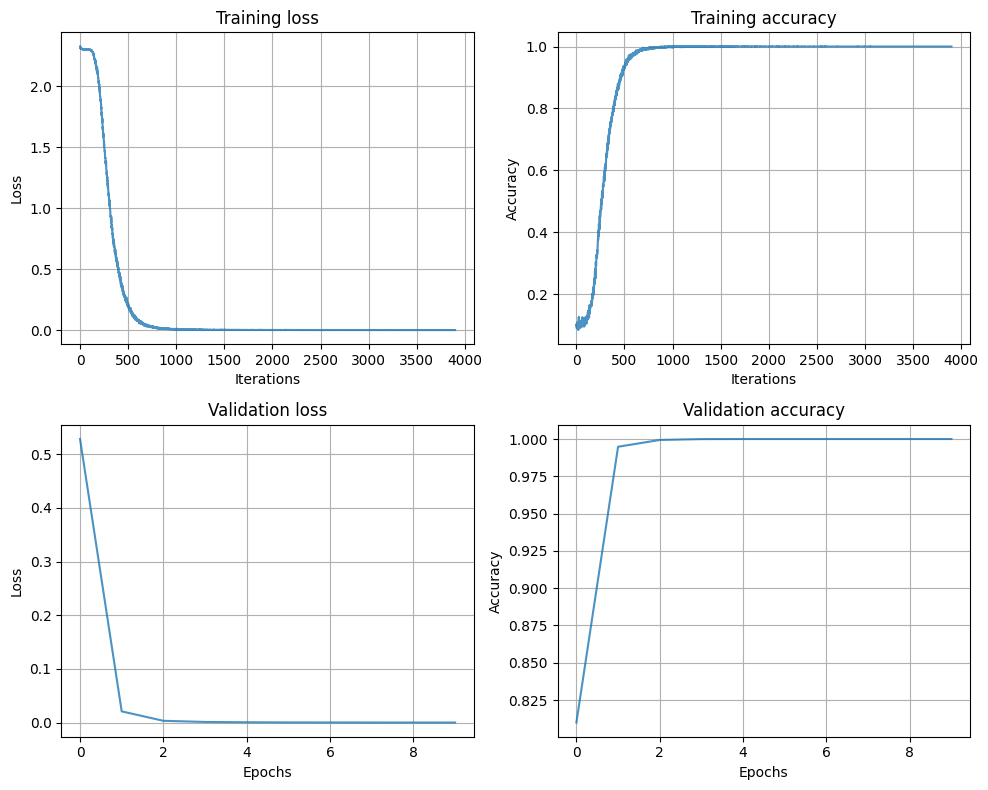

In [82]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), tight_layout=True)

axes[0, 0].set_title("Training loss")
axes[0, 0].plot(losses, alpha=0.8)
axes[0, 0].grid()

axes[0, 1].set_title("Training accuracy")
axes[0, 1].plot(accs, alpha=0.8)
axes[0, 1].grid()

axes[1, 0].set_title("Validation loss")
axes[1, 0].plot([x[0] for x in val], alpha=0.8)
axes[1, 0].grid()

axes[1, 1].set_title("Validation accuracy")
axes[1, 1].plot([x[1] for x in val], alpha=0.8)
axes[1, 1].grid()

# set labels
axes[0, 1].set_xlabel("Iterations")
axes[0, 0].set_xlabel("Iterations")
axes[1, 1].set_xlabel("Epochs")
axes[1, 0].set_xlabel("Epochs")

axes[0, 0].set_ylabel("Loss")
axes[0, 1].set_ylabel("Accuracy")
axes[1, 0].set_ylabel("Loss")
axes[1, 1].set_ylabel("Accuracy")

plt.show()

**Question 7**: What happens when removing the positional encoding from the encoder network above with the performance of the network?

**Question 8** (Optional): Why is the performance still better than random guessing? What does the network learn in this case?

_Hint_: For the last question you will probably need to run a few examples through the trained encoding-less network and think about how the dataset is created.

In [83]:
# test the model on the unseen test data
test_accs = []
for b in test_loader:
    loss, acc = compute_loss(encoder_model, b)
    test_accs.append(acc)

print("Test set performance", np.mean(test_accs))

Test set performance 0.9999938


In [84]:
# test sample...
test = torch.Tensor([[1, 2, 3, 4, 5, 6, 6, 6, 7, 1, 2, 8, 9, 5, 3, 9]]).type(torch.LongTensor)
print(test)
test = torch.nn.functional.one_hot(test, num_classes=num_classes).float()

output, att = encoder_model(test)

print(torch.argmax(output.squeeze(), dim=1))

tensor([[1, 2, 3, 4, 5, 6, 6, 6, 7, 1, 2, 8, 9, 5, 3, 9]])
tensor([9, 3, 5, 9, 8, 2, 1, 7, 6, 6, 6, 5, 4, 3, 2, 1])


In the cell below, you can see a visualization of the two attention matrices of the transformer encoder.

**Question 9**: Can you intepret the pattern in these attention matrices?

_Hint_: Find the largest elements in the matrix to verify your answer.

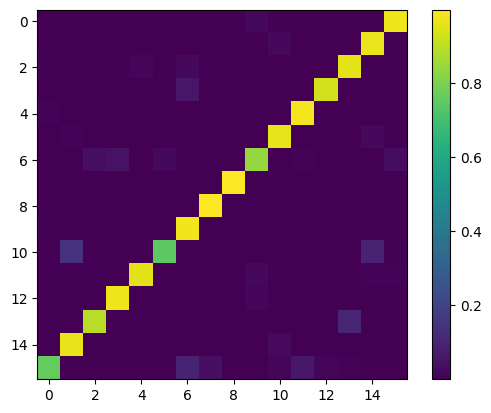

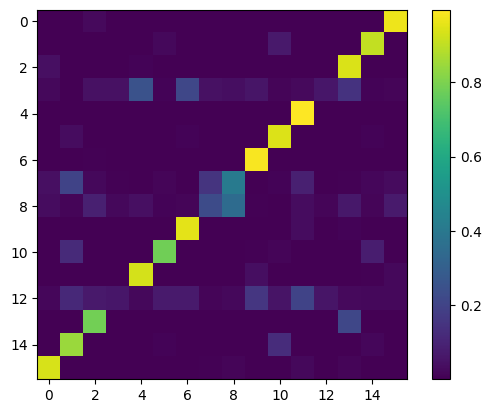

In [85]:
# visualize the attention maps
att_maps = att[0]

plt.imshow(att[0][0, 0].detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(att[0][0, 1].detach().numpy())
plt.colorbar()
plt.show()

## Part 2b: Sequence generation task

In the second example, we train a decoder model to generate text. In this part of the lab we are using the tiny sheakspear dataset. It is a small dataset containing the plays by Shakespear. First, we need to obtain the data and read it in. We use every single character as an individual token. Therefore, we first find out the number of distinct characters in all the plays and then create a mapping from each character to a unique number.

For this task it is also nice to use a GPU e.g. on google colab to get a faster training. However, the model can also be trained locally on a CPU and the training time should still be relativly fast.

In [86]:
device = "cuda" # TODO: you can change the device to cuda if you are using colab or a local graphics card.

Let's start by loading the data. Quickly scan the code below and verify that the functions implement the described behaviour above.

In [87]:
# load the dataset
! wget https://raw.githubusercontent.com/uu-sml/course-dl-public/refs/heads/main/Lab2/input.txt

--2026-02-25 06:53:30--  https://raw.githubusercontent.com/uu-sml/course-dl-public/refs/heads/main/Lab2/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2026-02-25 06:53:30 (34.3 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [88]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [89]:
# let's take a quick look at the text :)
text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [90]:
# we do character level encoding here:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Using vocab size {vocab_size}")

Using vocab size 65


In [91]:
# Create a mapping from characters to integers and back.
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # Encoder: Take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: take a list of integers, output a string

Now we can get started to implement a decoder model that we can then use for autoregressive sampling to generate new text sequences.

To accomplish this, we first have to adjust the self attention module from above to use causal self attention i.e. only attend to tokens that are ahead in the sequence to them to allow us to efficiently train the model.

To get started on this task, copy the code for the multi-head attention implementation in the cell blow. When computing the self-attention scores, we now want to make sure that each token only attends to tokens that come before the token itself in the sequence.
This can be achieved by applying a triangular masking to the attention weights.
Remember to apply the triangular masking on the unnormalized attention weights before applying the softmax function in order to make sure the columns normalize to one in the attention matrix.

**Task 8**: Implement these changes by adding the masking of the self attention matrix in the forward pass in the new class below that we use for causal self-attention in the decoder that we impelment in the next step.

In [92]:
class MultiHeadCausalSelfAttention(torch.nn.Module):

    def __init__(self, num_heads, embedding_dimension):
        super().__init__()
        assert embedding_dimension % num_heads == 0
        self.num_heads = num_heads

        self.key   = torch.nn.Linear(embedding_dimension, embedding_dimension, bias=False)
        self.query = torch.nn.Linear(embedding_dimension, embedding_dimension, bias=False)
        self.value = torch.nn.Linear(embedding_dimension, embedding_dimension, bias=False)
        self.proj  = torch.nn.Linear(embedding_dimension, embedding_dimension, bias=False)

    def forward(self, x):
        B, N, D = x.size()
        H = self.num_heads
        head_dim = D // H

        Q = self.query(x).view(B, N, H, head_dim).transpose(1, 2)
        K = self.key(x).view(B, N, H, head_dim).transpose(1, 2)
        V = self.value(x).view(B, N, H, head_dim).transpose(1, 2)

        att = (Q @ K.transpose(-2, -1)) * (head_dim ** -0.5)

        # TODO: Task 8 — apply causal mask so each token only attends to previous tokens
        mask = torch.tril(torch.ones(N, N)).to(x.device)
        att = att.masked_fill(mask == 0, float('-inf'))
        att = torch.nn.functional.softmax(att, dim=-1)

        x = (att @ V).transpose(1, 2).contiguous().view(B, N, D)
        x = self.proj(x)

        return x, att

Now we have implemented the causal self-attention mechanism. To verify the implementation look at the attention matrix below for a random input.

**Question 10**: What is the pattern in the attention matrix you can see? Why do we use this structure for the attention matrix here?

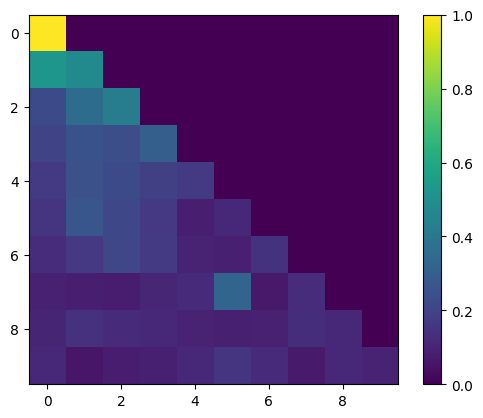

In [93]:
# random input to test the implementation
x = torch.empty((2, 10, 32)).normal_()
out, att = MultiHeadCausalSelfAttention(4, 32)(x)

# plot the attention matrix
plt.imshow(att[0, 0].detach().numpy())
plt.colorbar()
plt.show()

A decoder block and Transformer decoder are very similar to the encoder block and the architecture but utilizes causal self-attention instead. However, we need to make some small adjustments to the task in order to get a good performance:
- Instead of using a one-hot encodings for the tokens here, we learn an embedding for each of the 65 tokens to a vector of the embedding dimension that we can choose as a hyper-parameter. For both the positional encoding and the token embedding you should now have a torch.nn.Embedding module.
- The final predictive networks also needs adjustment where we want to increase the hidden dimension and choose the correct output dimension. For the hidden dimension you can choose for example 4 times the embedding dimension of the network. The output dimension is equal to the number of avialble classes.

**Task 9**: Implement the changes for the decoder architecture below, for this you only need to swap out the full attention in the encoder block with the masked attention module.

_Hint_: Remember that we use the `cross-entropy` loss which means that we do not manually add a `softmax` to the output.

In [94]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, num_heads, embedding_dimension):
        super().__init__()
        self.ln1  = torch.nn.LayerNorm(embedding_dimension)
        self.attn = MultiHeadCausalSelfAttention(num_heads, embedding_dimension)
        self.ln2  = torch.nn.LayerNorm(embedding_dimension)
        self.mlp  = MLP(embedding_dimension)

    def forward(self, x):
        x_attn, att_w = self.attn(self.ln1(x))
        x = x + x_attn
        x = x + self.mlp(self.ln2(x))
        return x, att_w


class TransformerDecoder(torch.nn.Module):

    def __init__(self, num_layers, num_heads, embedding_dimension, sequence_length):
        super().__init__()

        self.layers = torch.nn.ModuleList([DecoderBlock(num_heads, embedding_dimension) for _ in range(num_layers)])

        # token and positional embeddings
        self.token_embedding = torch.nn.Embedding(vocab_size, embedding_dimension)
        self.pe              = torch.nn.Embedding(sequence_length, embedding_dimension)

        # predictor
        self.predictor = torch.nn.Sequential(
            torch.nn.Linear(embedding_dimension, 4 * embedding_dimension),
            torch.nn.GELU(),
            torch.nn.Linear(4 * embedding_dimension, vocab_size),
        )

    def forward(self, x):
        B, N = x.shape

        tok_emb = self.token_embedding(x)
        pos_emb = self.pe(torch.arange(N, device=x.device))
        x = tok_emb + pos_emb

        for l in self.layers:
            x, _ = l(x)

        x = self.predictor(x)
        return x

Now, we encode the loaded text data into numerical values and split it into training and test sets. We also implement a function to generate batches from the text data. In decoder models, the task is to predict the next token (in this case, a character) for each input. Therefore, the batch function returns the input shifted one position to the right as the target output.

In [95]:
# Encode the data to numerical values
data = torch.tensor(encode(text), dtype=torch.long)

# First 90% will be train, rest val
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

# hyper-parameters
block_size = 128
batch_size = 64

# get a batch of data
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

After the model is trained, we want to sample from it in an autoregressive manner. That means we input a sequence of tokens into the model and compute the probability distribution over the next possible token by the network output. Then we append the newly generated token to the input and repeat this sampling process for a fixed number of steps.

**Task 10**: Implement the sampling in the method below. As the next token, choose the output that is predicted to be most likely by the network.

_Feel free to change the default prompt to something more exciting._

In [96]:
def sample(model, sample_length=100, prompt="The"):
    prompt = torch.tensor(encode(prompt), dtype=torch.long).reshape(1, -1).to(device)

    for _ in range(sample_length):
        # TODO: Task 10 — sample the next token predicted from the decoder network
        output = model(prompt)
        next_token = output[0, -1, :].argmax(dim=-1, keepdim=True)

        # add the new sample to the prompt:
        prompt = torch.cat((prompt, next_token.reshape(1, -1)), dim=1)

    # decode the generated sequence and print it
    t = decode(prompt.squeeze().tolist())
    print(t)

We can check if the sampling function works in principal by creating a model and sampling from the output. Since the model is not trained yet, the output will be just a collection of random letters here.

In [97]:
# sequence length is the maximum length an input sequence can have.
transformer = TransformerDecoder(num_layers=3, num_heads=4, embedding_dimension=128, sequence_length=256)
transformer.to(device)

# check if the model forward pass and sampling
sample(transformer, sample_length=20)

TheV3'qXXXXXRXXiXX,Oj?H


Now, we can start training our model using the code below.

_Note_: You can also change the network architecture but bigger models are slower to train and require more compute. Using the standard architecture outlined here, the training takes around 20 minutes on my laptop without any GPU access. The final loss achieved in the model is $1.31$. If your loss is significantly lower you probably have some leakage during training and you should double check the architecture.

You should see a significant improvement over the random sampling in the model but the output might not make a lot of sense due to the small scale of the computations used here. Training the model longer is not required to complete the lab.

In [98]:
optimizer = torch.optim.AdamW(transformer.parameters())

max_iter = 5_000

losses = []
vals = []

eval_freq = 100

for i in range(max_iter):

    # get the training datta
    xb, yb = get_batch('train')

    # compute the predictions
    pred = transformer(xb)

    # reshape the output and target and compute the loss
    B, N, D = pred.shape
    logits = pred.view(B*N, D)
    targets = yb.view(B*N)

    loss = torch.nn.functional.cross_entropy(logits, targets)
    losses.append(loss.detach().item())

    # compute the backward pass and update parameters
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # do evaluation
    if i % eval_freq == 0:

        # run validation data
        transformer.eval()
        with torch.no_grad():
            val_loss = 0
            for _ in range(10):
                xb, yb = get_batch('val')
                pred = transformer(xb)
                B, N, D = pred.shape
                logits = pred.view(B*N, D)
                targets = yb.view(B*N)
                val_loss += torch.nn.functional.cross_entropy(logits, targets).item()
            val_loss /= 10

        vals.append(val_loss)

        transformer.train()

        print(f"Iteration: {i}\t training loss: {loss.item():.2f}\t validation loss: {val_loss:.2f}")
        sample(transformer)
        print("----")

Iteration: 0	 training loss: 4.26	 validation loss: 3.97
Thedeaes au.
d l lhau. . aue auaudeas  deaue aO,L&LbIy acdLit ahesahIauzahj ahqT.d aujE,bqyLLae ah&auau
----
Iteration: 100	 training loss: 2.44	 validation loss: 2.48
The the the the the the the the the the the the the the the the the the the the the the the the the the
----
Iteration: 200	 training loss: 2.24	 validation loss: 2.28
The the the the the theat the the there thererere the thereat ther there the
The the there theat there 
----
Iteration: 300	 training loss: 2.01	 validation loss: 2.12
The the the the the the theere the thee thee theare the thee there
The the thee the the theave the thea
----
Iteration: 400	 training loss: 1.90	 validation loss: 2.00
The have the the with the the deare the the wast
The the seare the the stand the with the stand the the
----
Iteration: 500	 training loss: 1.81	 validation loss: 1.94
The will the with the well the with the well the sould
The streak the with have with the would his fair

**Question 11** (Optional): What is the loss we expect before training the model? Why is the loss going down so fast in the beginning?

Next, we can visualize the loss over the iterations

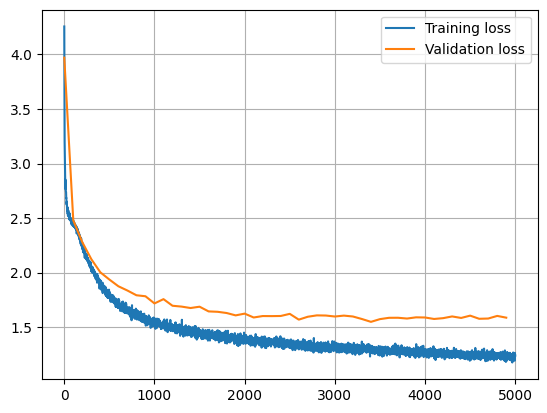

In [99]:
plt.plot(losses, label="Training loss")
plt.plot(np.arange(0, max_iter, eval_freq), vals, label="Validation loss")
plt.legend()
plt.grid()
plt.show()

Now that our model is trained, you can again draw samples from the model. You can also change the initial prompt to get different starting points for the sample drawing.

In [100]:
# draw samples from the trained model
prompt = "And..."
sample(transformer, prompt=prompt)

And...

LARTIUS:
What is the matter of the seast, and the sea,
That when the season of the season of the s


__Question 11__: Using the current sampling strategy, the network output is deterministic. How could you change the sampling such that the network can produce multiple output sequences for a single input? (_You do not have to implement these changes_)

Note that we use a very small language model here. If you want to get some better results you would need a larger model which requires more training. However, the implementation you have done here basically includes all the components that the GPT and similar model families include. By simply changing the hyper-parameters you can reimplement GPT-2 in this lab (which is the last model in the GPT architecture where the model is well described in a research paper).

More modern models add a lot of computational tricks in order to make the model more scalable and so on but the underlying principles are the same as the ones you have implemented yourself in this lab.

## Summary & Outlook

In this lab you have seen how to implement a transformer using a single head or multiple heads either using a decoder style model for sequence-to-sequence tasks and a small example for a decoder model. The code you have written includes everything the basic GPT models consist of.

Hopefully, this lab has given you some hands on experience with the transformer architecture to understand what is going on under the hood of these models that run here.

The examples shown here are toy examples that show the potential power of transformers but are in themselves fairly easy. However, transformers nowadays are capable of remarkable performances. While this course covers the basics for the transformer architecture, you will see similar models again in follow up courses:

- _Large Language Models and Societal Consequences of Artificial Intelligence_ where the focus will be on building an LLM application, leveraging transformers for text and language, and exploring their impact. Through the assignments, you will work with state-of-the-art LLMs.
- _Advanced Deep Learning for Image Processing_ is a course focusing on deep learning models for images and also covers the suprising competetivness of transformers on image data called vision transformers (ViT).